# A short introduction to widgets

---

## Overview
Jupyter notebooks make coding environments considerably more approachable, but periodically, it can be useful to use interactive widgets like sliders or dropdowns or similar to explore data.  For example, suppose you want to look at plots corresponding to conditions on a finite set of dates, it would be convenient to select a date of interest from a dropdown see a plot, and then select a different date and see the plot updated in place. 

In another notebook, we'll put these widgets to work to explore data, but here we'll give a quick overview of a couple of technical issues: 

1. Plotting a spatiotemporal data set
1. Implementing a drop down menu to control the dependent variable plotted
1. Implementing multiple drop down menus to control the variable on each axis

- **Time to learn**: 10 minutes

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| Matplotlib | Helpful | |

---

## Imports

In [1]:
import sys
import seaborn as sns

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pyleoclim as pyleo
import xarray as xr

## Machinery under the hood

There is an evolving set of options for extending jupyter notebooks with widgets.  Here we'll focus on those supported by jupyter itself ([ipywidgets](https://ipywidgets.readthedocs.io/en/stable/index.html)). 

In the simplest sense, we need:
- an initial object (like a figure)
- a widget
- one or more function(s) describing what to do when the widget selection has changed (for a plot this often includes instructions about whether to keep or clear actions done by the previous selection and instructions about updating according to the current selection)


Let's load some data from the Last Millennium Reanalysis Project via [Pangeo-Forge](https://pangeo-forge.org/), and give it a test run.

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Hakim, G. J., Emile-Geay, J., Steig, E. J., Noone, D., Anderson, D. M., Tardif, R., Steiger, N., and Perkins, W. A. (2016), The last millennium climate reanalysis project: Framework and first results, J. Geophys. Res. Atmos., 121, 6745– 6764, doi:10.1002/2016JD024751.|
| Tardif, R., Hakim, G. J., Perkins, W. A., Horlick, K. A., Erb, M. P., Emile-Geay, J., Anderson, D. M., Steig, E. J., and Noone, D.: Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling, Clim. Past, 15, 1251–1273,  https://doi.org/10.5194/cp-15-1251-2019 , 2019. |

In [2]:
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1409/LMRv2p1_MCruns_ensemble_ungridded.zarr"
lmr_ds_ungridded = xr.open_dataset(store, engine='zarr', chunks={})
lmr_ds_ungridded

<xarray.Dataset>
Dimensions:              (time: 2001, MCrun: 20, members: 100, lat: 24, lon: 81)
Coordinates:
  * lat                  (lat) float32 20.0 22.0 24.0 26.0 ... 62.0 64.0 66.0
  * lon                  (lon) float32 100.0 102.0 104.0 ... 256.0 258.0 260.0
  * time                 (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:...
Dimensions without coordinates: MCrun, members
Data variables:
    amo                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    ao                   (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    ensmean_pdo_idx      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ensmean_pdo_pattern  (lat, lon) float32 dask.array<chunksize=(24, 81), meta=np.ndarray>
    gmt                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nao                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nhmt                 (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nino34               (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    pdo                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    sam                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    shmt                 (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    soi                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
Attributes:
    comment:                   File contains full ensemble values for each Mo...
    description:               Last Millennium Reanalysis climate field recon...
    experiment:                productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_tas
    pangeo-forge:inputs_hash:  51192b3d1b2a5bf9297cd3e6d03e1f98e202d6571545d5...
    pangeo-forge:recipe_hash:  c41d1ef8f142f43547e95f9e75160849d7554e2afaad4e...
    pangeo-forge:version:      0.9.2

That's a bunch of interesting data, but for our purpose, let's make a pandas dataframe out of a small slice of it. (It might take a minute.)

In [3]:
# Make a pandas dataframe with a few variables for ease of use
vars_subset = ['nhmt', 'shmt', 'gmt']
df = lmr_ds_ungridded.sel(MCrun=1)[vars_subset].chunk({'time':1}).groupby('time.year').mean('members').to_dataframe(dim_order=['time'])
df.index = df.index.year
df.index.name = 'year'

In [4]:
ts_d = {}
colors = ['crimson', 'navy', 'darkseagreen']
for ip, var in enumerate(vars_subset):
    ts_d[var] = {'series':pyleo.Series(df.index, df[var], time_unit='Year', 
                             clean_ts=False, value_name='temp anomaly', 
                             value_unit = '$^{\circ}$C', label=var),
                 'color':colors[ip]}

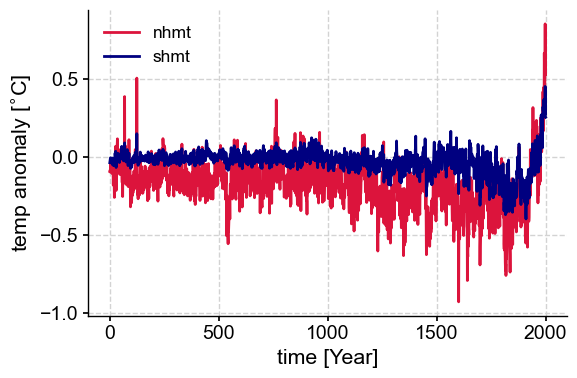

In [5]:
# Basic plot
fig, ax = plt.subplots(1,1, figsize=(6,4))
ts_d['nhmt']['series'].plot(ax=ax, legend=False, color=ts_d['nhmt']['color'])
ts_d['shmt']['series'].plot(ax=ax, legend=False, color=ts_d['shmt']['color'])
ax.legend()
plt.tight_layout()


### Base Case

#### 1.) a function to act on the data
Let's wrap the instructions about making this plot in a function that takes an input we will control with a widget.  

In [15]:
# Function to plot data
def plot(var, ax):
    ts_d[var]['series'].plot(ax=ax, color=ts_d[var]['color'], legend=False)
    plt.tight_layout()

Now we'll make a function that clears the previous content of the plot and then runs our plotting function. If we don't do this, the figure will accumulate lines for every selection. 

In [7]:
# Function to clear previous content and update based on new selection
def update_from_dropdown(val):
    # handle whether the input is coming from the dropdown or setup
    if type(val) == str:
        var =val
    else:
        var = val.new
    
    # plot new selection
    plot(var, ax1)
    
    ax1.set_ylabel('temp anomaly'+' [$^{\circ}$C]')
    ax1.legend()
    fig.canvas.draw_idle()

    
def on_bclear_clicked(b):
    with output:
        for line in ax1.lines: # put this before you call the 'mean' plot function.
            line.set_label(s='')
        ax1.cla()

#### 2.) a widget
A good option here might be to create a dropdown of the various variables. 

In [8]:
%matplotlib ipympl
# Initialize a dropdown widget
dropdown = widgets.Dropdown(
    value='nhmt', 
    options=ts_d.keys(), 
    description='LMR vars', 
    layout={'width': 'initial'}
)

# button that will clear the plot
bclear = widgets.Button(description='Clear')

output = widgets.Output()

#### 3.) initialize the plot and turn on the widget

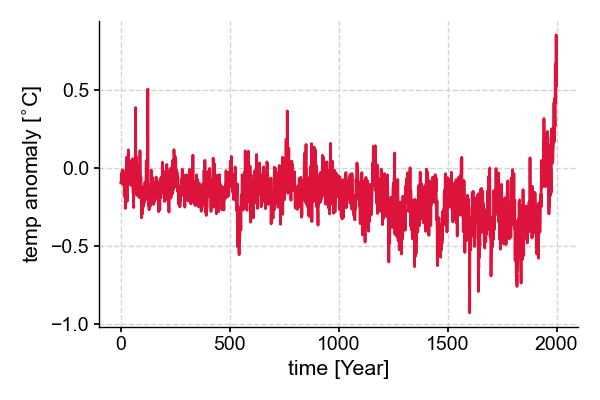

In [18]:
%matplotlib ipympl
plt.close('all')
fig, ax1 = plt.subplots(figsize=(6,4))
fig.subplots_adjust(bottom=0.2)

# Plot initial content
init_var = 'nhmt'
plot(init_var, ax1)

# Start widget "observing"
dropdown.observe(update_from_dropdown, 'value') # same dropdown, different behavior
bclear.on_click(on_bclear_clicked)

# render dropdown widget
widget_box = widgets.HBox([dropdown,bclear])
widgets.HBox([output, widget_box])

## Using widgets to change analysis

In [36]:
# Function to plot data
def plot(x=None, y=None, hue=None, ax=None):
    print(x,y,hue)
    ax.cla()
    if x == 'year':
        sns.lineplot(data=df, x=x, y=y, ax=ax)
    else:
        sns.scatterplot(data=df, x=x, y=y, hue=hue, ax=ax)
    plt.tight_layout()

In [43]:
# Function to clear previous content and update based on new selection
def update_x(val):
    # handle whether the input is coming from the dropdown or setup
    if type(val) == str:
        var =val
    else:
        var = val.new
        
    x = var
    y=dropdown_y.value
    hue=dropdown_hue.value
    
    # plot new selection
    plot(x=x, y=y, hue=hue, ax=ax1)
    fig.canvas.draw_idle()

def update_y(val2):
    # handle whether the input is coming from the dropdown or setup
    if type(val2) == str:
        var2 = val2
    else:
        var2 = val2.new
        
    y = var2
    x=dropdown_x.value
    hue=dropdown_hue.value
    
    # plot new selection
    plot(x=x, y=y, hue=hue, ax=ax1)
    fig.canvas.draw_idle()

def update_hue(val1):
    # handle whether the input is coming from the dropdown or setup
    if type(val1) == str:
        var1 =val1
    else:
        var1 = val1.new
        
    hue = var1
    x=dropdown_x.value
    y=dropdown_y.value

    # plot new selection
    plot(x=x, y=y, hue=hue, ax=ax1)
    fig.canvas.draw_idle()
    
def on_bclear_clicked(b):
    with output:
        for line in ax1.lines: # put this before you call the 'mean' plot function.
            line.set_label(s='')
        ax1.cla()

In [44]:
# %matplotlib ipympl
# Initialize widgets
dropdown_x = widgets.Dropdown(
    # value='', 
    options=['gmt', 'nhmt', 'shmt', 'year'], 
    description='x axis', 
    layout={'width': 'initial'}
)

dropdown_y = widgets.Dropdown(
    # value='', 
    options=['gmt', 'nhmt', 'shmt', 'year'], 
    description='y axis',
    layout={'width': 'initial'}
)

dropdown_hue = widgets.Dropdown(
    # value='', 
    options=['gmt', 'nhmt', 'shmt', 'year'], 
    description='hue', 
    layout={'width': 'initial'}
)

output = widgets.Output()

gmt gmt gmt


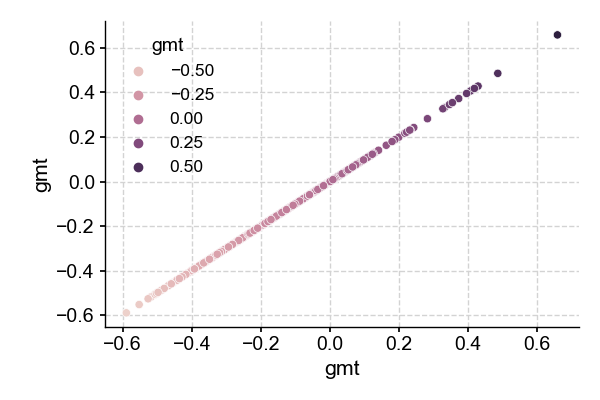

In [45]:
%matplotlib ipympl
plt.close('all')
fig, ax1 = plt.subplots(figsize=(6,4))
fig.subplots_adjust(bottom=0.2)

# Plot initial content
y = dropdown_y.value
x = dropdown_x.value
hue = dropdown_hue.value

plot(x, y, hue, ax1)

# Start widget "observing"
dropdown_x.observe(update_x, 'value') # same dropdown, different behavior
dropdown_y.observe(update_y, 'value') # same dropdown, different behavior
dropdown_hue.observe(update_hue, 'value') # same dropdown, different behavior

# render dropdown widget
widget_box = widgets.VBox([dropdown_x, dropdown_y, dropdown_hue])
widgets.HBox([output, widget_box])


---

## Summary
This is a bare-bones example of how to implement widgets, alone and in concert with each other. There are an assortment of other widget ([options](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)) just waiting for investigation, but we will leave that as an exercise for the intrepid reader. 

## What's next?
To see widgets in action, check out the science bit about [climatic response to volcanic events](../science_bits/VICS_dashboard.ipynb).